## Tutorial - Voltammetry analysis step-by-step

This notebook walks you through how to analyze voltammmetry data that has been previously acquired and stored in "axon binary file" (abf) format. 


### Preprocessing
The "voltammetry" module included in this repository has several tools to load and view data. First, let's convert load the relevant packages and preprocess the data.

In [1]:
# load packages
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import voltammetry
abfpath = 'Tutorial_LABS_data'
sorted(os.listdir(abfpath))

['.DS_Store',
 'Tutorial_LABS_data_0000.h5',
 'Tutorial_LABS_data_0001.h5',
 'Tutorial_LABS_data_0002.h5',
 'Tutorial_LABS_data_0003.h5',
 'Tutorial_LABS_data_0004.h5',
 'Tutorial_LABS_data_0005.h5',
 'Tutorial_LABS_data_0006.h5',
 'Tutorial_LABS_data_0007.h5',
 'Tutorial_LABS_data_0008.h5',
 'Tutorial_LABS_data_0009.h5',
 'Tutorial_LABS_data_0010.h5',
 'Tutorial_LABS_data_0011.h5',
 'Tutorial_LABS_data_0012.h5',
 'Tutorial_LABS_data_0013.h5',
 'Tutorial_LABS_data_0014.h5',
 'Tutorial_LABS_data_0015.h5',
 'Tutorial_LABS_data_0016.h5',
 'Tutorial_LABS_data_0017.h5',
 'run.csv']

This data set contains 18 experiments with the extension ".h5" and a file with labels corresponding to each experiment. Each experimental data file has two matrices: 

'CMD' = the forcing funciton used for frame. [frame point count X # frames]
'Voltammogram' = current trace for each frame. [frame point count X # frames]

['CMD', 'Voltammogram']
<HDF5 dataset "CMD": shape (1032, 10000), type "<f8">
<HDF5 dataset "Voltammogram": shape (1032, 10000), type "<f8">


Text(0, 0.5, 'voltage (mV)')

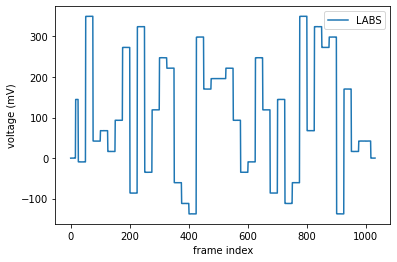

In [2]:
# load single data file
d0 = h5py.File('Tutorial_LABS_data/Tutorial_LABS_data_0000.h5','r')
print(list(d0.keys()))
print(d0['CMD'])
print(d0['Voltammogram'])
plt.plot(d0['CMD'][:,0])
plt.legend({'LABS'})
plt.xlabel('frame index')
plt.ylabel('voltage (mV)')

The votammogram data and labels can be loaded and converted to the proper format

In [3]:
vg = voltammetry.Data(abfpath)
labels = voltammetry.Mulabels(abfpath, 'run.csv')

In [4]:
# Plot single voltammogram for each experiment. Note values above 2000 nA are cut off and drop down
# to minimum of -2000 nA.

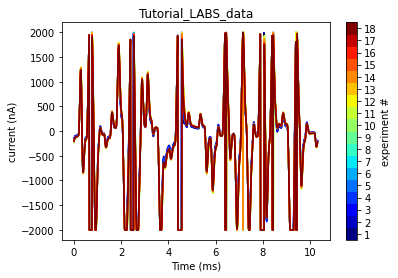

In [5]:
vgram_fig = vg._plotVoltammograms()

Select the data to be analyzed and preprocess the data.
The 1032 long frames contain leading and trailing data points, 16 each that must be removed.
A 1500 frame window will be selected from the entire 10000 frames for each experiment based on the the most
stable median value.Points set to minimum and flipped to maximum to reduce overflow error. ** This can be time consuming.**

In [6]:
data = voltammetry.PreprocessedData(vg.Voltammogram[16:1016], labels,window_size=1500,trainingSampleSize=125,corr_over=True)

Correcting overflow negative values
Start partition
Finding stable section with window size 1500
Partitioning data with training sample size 125
Flattening Data
PRE-PROCESSING COMPLETE!!!!


Observe the input shape of the corrected voltammogram.

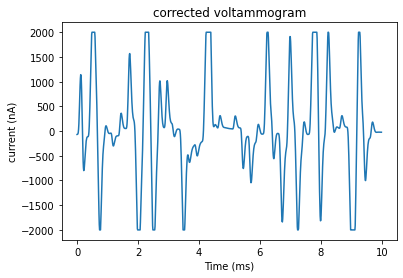

In [7]:
y = data.training.vgrams[0,:]
x = np.arange(len(y))/100 # scale x bashed on 100 kHz sampling rate
plt.plot(x,y)
plt.title('corrected voltammogram')
plt.xlabel('Time (ms)')
plt.ylabel('current (nA)');

As an alternative to background subtraction, the voltammograms are differentiated with respect to index.

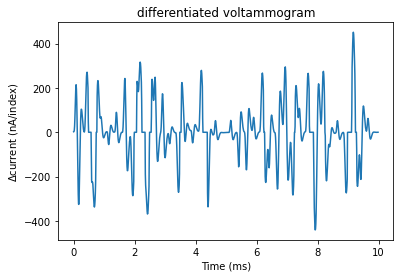

In [8]:
y = np.diff(data.training.vgrams[0,:])
x = np.arange(len(y))/100 # scale x bashed on 100 kHz sampling rate
plt.plot(x,y)
plt.title('differentiated voltammogram')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$current (nA/index)');

### Training Elastic-Net Penalized Regression
The software package GLMnet computes the $\lambda$ which minimizes the 10-fold cross validation error. A function was written to itterate over values of $\alpha$ from 0 to 1 in steps of 0.1. The partitioned training data will be used as input and the model is then validated on the testing data. 

More detailed informaiton on GLMnet can be found at https://glmnet-python.readthedocs.io/en/latest/glmnet_vignette.html.

In [9]:
# train cvglmnet model
max_core = 8 # maxmum number of corest that can be used in parallel by machine for training
# Search for the best alpha from 0 to 1 in steps of 0.1
bestAlpha = voltammetry.best_alpha(data.training)

cvFit = voltammetry.train_analyte(data.training, alpha=bestAlpha,parallel=max_core)

[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores


TRAINING COMPLETE 136.172  seconds. 

Best alpha =  1.0  (error =  841.81 )

TRAINING COMPLETE  39.304  seconds. 



In [10]:
# generate predictions
predictions = voltammetry.test_analyte(data.testing, cvFit)

### Results
The predictions of the elastic net penalized linear regression model can be evaluated by comparing true values to predicted values. Below the calibration of the model is visualized as the individual predicitons in a time series, along with root-mean-squared error and signal-to-noise ratio at each concentration.

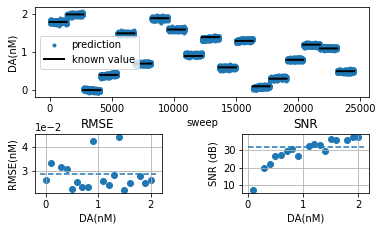

In [11]:
# Generate predictions, plot results
chemIx = 0 # only one analyte
t = np.arange(len(data.testing.labels))
stats = voltammetry.calcStepStats(chemIx, predictions, data.testing.labels)
[calFig,ax1,ax2,ax3] = voltammetry.plot_Calibration(t, predictions, data.testing.labels, labels.targetAnalyte, chemIx, stats)

We can also visualize some aspects of the model, including the linear regression coefficients generated for the model.

Text(0.5, 0, 'frame position')

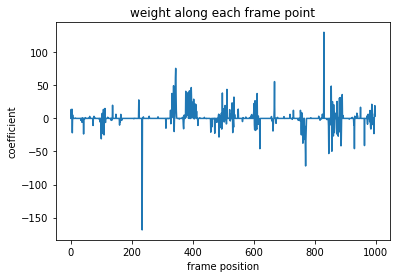

In [13]:
# plot betas
from glmnet_python import cvglmnetCoef
betas = cvglmnetCoef(cvFit, 'lambda_min')
#plt.figure(dpi=200)
plt.plot(np.squeeze(betas[0])[1::]) # the first element is the offset, omit when plotting
plt.title('weight along each frame point')
plt.ylabel('coefficient')
plt.xlabel('frame position')

The above tutorial should provide a guide for using models and interpretting voltammetry data. The same basic steps are used in the Dopamine_Norepinephrine.ipynb, "Comparing_linear_sweep_random_burst.ipynb",and "Ensemble_model_example.ipynb" demos.

Thank you.

In [14]:
## Credits
import sys, platform, time
print('This tutorial was created using:')
print('Python Version:',sys.version)
print('Operating System:',platform.system(),'Version',platform.release())
print('GLMnet for python: https://web.stanford.edu/~hastie/glmnet_python/')
print('Numpy: https://numpy.org/')
print('h5py: http://www.h5py.org/')
print('pyplot: https://matplotlib.org/index.html')
print('Last updated:',time.strftime('%d-%b-%Y %H:%M:%S',time.localtime()))


This tutorial was created using:
Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Operating System: Darwin Version 18.7.0
GLMnet for python: https://web.stanford.edu/~hastie/glmnet_python/
Numpy: https://numpy.org/
h5py: http://www.h5py.org/
pyplot: https://matplotlib.org/index.html
Last updated: 20-Dec-2020 21:21:55
